In [57]:
### If You do not have one of these packages, you can simply run: !pip install <package>

# You may also find this video helpful for permanent installations (basically installs folder to your drive)
# >> https://www.youtube.com/watch?v=ErwLcnvhW4A&t=473s

# You may also find this paper helpful for some intro information / description of optimizer algorithms
# >> https://arxiv.org/pdf/1803.08823

import torch
from fastai.tabular.all import *
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [58]:
import sympy as sym
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid

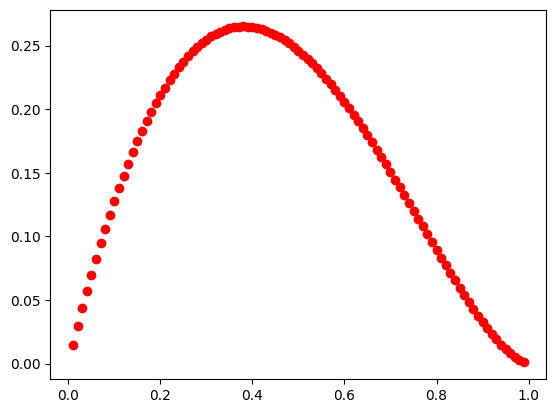

In [59]:
### Toy Model Parton Distribution Function

x = torch.arange(1,100).float()/100.

def h(x, params):

  N,a,b = params

  return N*x**a*(1-x)**b

def show(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    # ax.scatter(time, signal)
    ax.scatter(x, to_np(preds), color="red")
    plt.show()

sig_params = torch.abs(torch.randn(3)).requires_grad_()
# sig_params
signal = h(x, sig_params)
show(signal)

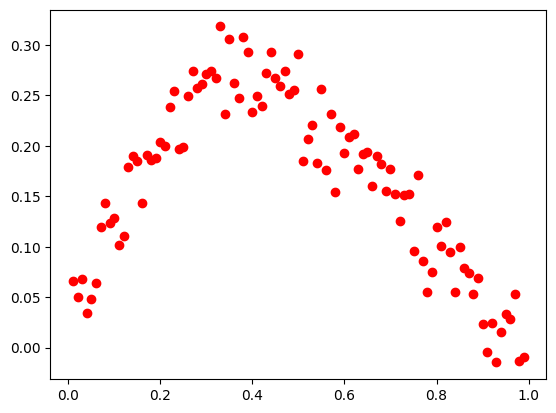

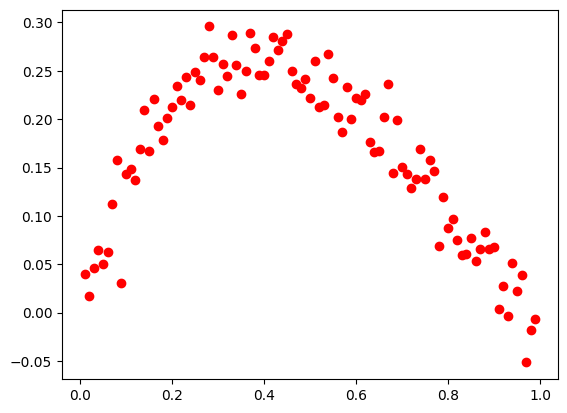

In [60]:
### Generate Data w/ Noise

# If we perform a fit with different pieces of noisey data to generate an uncertainty band \n
# This is known as the replica method (or monte carlo method) for generating uncertainty

N_train = 100
max_sig = max(signal.data)
min_sig = min(signal.data)
noise_amp = 0.1*(max_sig - min_sig)
X_train = []

for i in range(N_train):
  noise = torch.randn_like(signal)*noise_amp
  sample = signal + noise
  X_train.append(sample)

show(X_train[0])
show(X_train[30])

In [61]:
### Loss Functions

# Loss per sample
def mserr(preds, targets):
    return ((preds - targets) ** 2).mean()

# Loss per round of training (So takes in entire trainging set)
def batch_loss(preds):

  temp_loss = 0
  for i in range(N_train):

    temp_loss += mserr(preds, X_train[i])

  temp_loss /= N_train #average loss

  return temp_loss

In [62]:
##### DNN Regression

In [ ]:
##### Define Model for Collinear Modulation

### NN = NN(x, q_type); q_type is quark type (modulate pdf for each quark type to prouce g_1T)
### For moderate x, restrict to just valence (up and down)

### Need to normalize to N >> But N is a parameter? I guess just choose N = 1

### NN Definition

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            # Specify layers, followed by activation for that layer
            # What if you want different activations for different nodes?
            # When would that ^ be desireable?
            nn.Linear(nInput, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Softplus(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

    # def forward(self, zL, zh, hadron, lambda_bar):
    #     return(self.layers(zL, zh, hadron, lambda_bar))

### 2 input x, q_type
mlpCondensed = MLPcondensed(1,3,1)
DNN_model_1 = mlpCondensed

In [64]:
### Loss Function

def mse_f(preds, targets):

    # preds = model(x)

    return ((preds - targets) ** 2).mean()

def batch_loss(preds):

    loss = 0

    for n in range(N_train):

        targets = X_train[n]
        loss += ((preds - targets) ** 2).mean()

    return loss / N_train

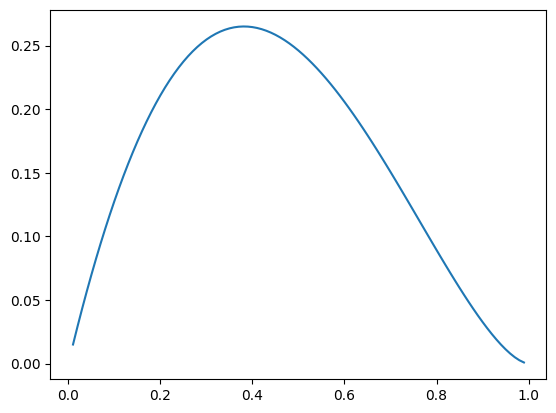

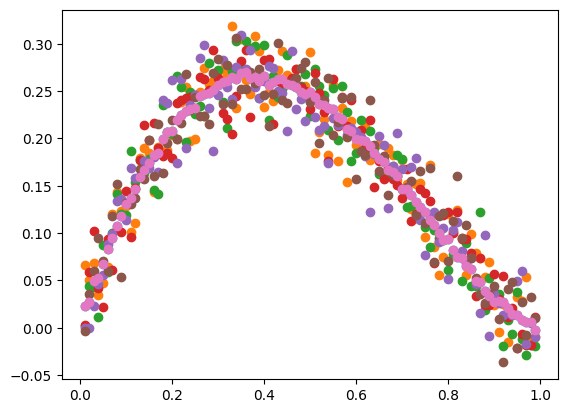

In [65]:
### Plot Central Values

# Just to see how the average data (the true function, if you like) compares across the entire set

plt.figure(0)
plt.plot(x.data, h(x, sig_params).data)


### Plot scattered central values

plt.figure(1)

avg_rep = torch.zeros(len(x))

for n in range(N_train):

    avg_rep += X_train[n]

avg_rep /= N_train

plt.scatter(x.data, avg_rep.data)
for i in range(5): plt.scatter(x.data, X_train[i].data)

plt.scatter(x.data, avg_rep.data)

In [66]:
# This is necessary for DNN_model_1 to serve as an input to our model

x_input = torch.reshape(x, (len(x), 1))

# Ex:
DNN_model_1(x_input).squeeze()

tensor([-0.2366, -0.2365, -0.2364, -0.2363, -0.2362, -0.2361, -0.2360, -0.2359,
        -0.2358, -0.2357, -0.2356, -0.2355, -0.2354, -0.2353, -0.2352, -0.2351,
        -0.2350, -0.2349, -0.2348, -0.2347, -0.2345, -0.2344, -0.2343, -0.2342,
        -0.2341, -0.2340, -0.2339, -0.2338, -0.2337, -0.2336, -0.2335, -0.2334,
        -0.2333, -0.2332, -0.2331, -0.2330, -0.2329, -0.2328, -0.2327, -0.2326,
        -0.2325, -0.2324, -0.2323, -0.2321, -0.2320, -0.2319, -0.2318, -0.2317,
        -0.2316, -0.2315, -0.2314, -0.2313, -0.2312, -0.2311, -0.2310, -0.2309,
        -0.2308, -0.2306, -0.2305, -0.2304, -0.2303, -0.2302, -0.2301, -0.2300,
        -0.2299, -0.2298, -0.2297, -0.2296, -0.2294, -0.2293, -0.2292, -0.2291,
        -0.2290, -0.2289, -0.2288, -0.2287, -0.2286, -0.2284, -0.2283, -0.2282,
        -0.2281, -0.2280, -0.2279, -0.2278, -0.2277, -0.2276, -0.2274, -0.2273,
        -0.2272, -0.2271, -0.2270, -0.2269, -0.2268, -0.2266, -0.2265, -0.2264,
        -0.2263, -0.2262, -0.2261], grad

In [67]:
### Organize data into batches
xObs = x
yObs = X_train[0]

for i in range(1, len(X_train)):

    xObs = torch.cat((xObs, x))
    yObs = torch.cat((yObs, X_train[i]))

In [68]:
### Organize Training Data

### They want to use Dataloaders in batches of 25 training points
### Apparently networks learn better this way

class nonLinearRegressionData(Dataset): #Dataset comes with some nice methods
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):

        # Reshape I think because need them to be matrices for network input
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
#d = nonLinearRegressionData(xObs, yObs)

#Here want batch size = full input, deterministic (no randomizing order even)
#train_dataloader = DataLoader(d, batch_size=len(x_input) , shuffle=False)

class newDataset(torch.utils.data.Dataset):
    def __init__(self, x_vals, y_samples):
        super().__init__()
        self.x_vals = x_vals.reshape(-1, 1).float()  # shape [N, 1]
        self.y_samples = y_samples                   # list of tensors, each shape [N]

    def __len__(self):
        return len(self.y_samples)  # number of noisy samples

    def __getitem__(self, idx):
        x = self.x_vals             # all x are the same for each sample
        y = self.y_samples[idx]     # different y each time
        return x, y

dataset = newDataset(x, X_train)
train_dataloader = DataLoader(dataset, batch_size=len(x_input) , shuffle=False)

In [69]:
### Train
from tqdm import tqdm

# Define the loss function and optimizer
mlpCondensed = MLPcondensed(1,10,1)
DNN_model = mlpCondensed
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(DNN_model.parameters(), lr=1e-2)
nTrainSteps = 30
#nTrainSteps = 60
initial_params = []

def training(a):
  torch.manual_seed(a)
  mlpCondensed = MLPcondensed(1,10,1)
  DNN_model_test = mlpCondensed
  # Got rid of momentum to turn this into regular gradient descent
  # Batch gradient descent (aka regular) since now SDG just takes all the data instead of getting different batches 
  # (In SDG each epoch it focuses on different batches)
  optimizer_2 = torch.optim.SGD(DNN_model_test.parameters(), lr=1e-2)
  initial_params.append(list(DNN_model_test.parameters()))
  # Track loss over epochs
  track_loss = np.zeros(nTrainSteps)
  #saved_data = 0 #for whatever training data was used
  # Run the training loop
  for epoch in tqdm(range(0, nTrainSteps)):
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):

      # Get inputs
      inputs, targets = data
      # Zero the gradients
      optimizer_2.zero_grad()
      # Perform forward pass (make sure to supply the input in the right way)
      #outputs = DNN_model_test(torch.reshape(inputs, (len(inputs), 1))).squeeze()
      outputs = DNN_model_test(inputs).squeeze()
      #saved_data = inputs
      # Compute loss
      loss = loss_function(outputs, targets)

      # Perform backward pass
      loss.backward(retain_graph = True)

      # Perform optimization
      optimizer_2.step()

      track_loss[epoch] = loss.item()

  #Changing so we're getting output from testing the model
  tested_output = DNN_model_test(x_input).squeeze().data
  #return track_loss, tested_output, a, list(DNN_model_test.parameters())# outputs, saved_data
  return track_loss, tested_output, a

# Process is complete.
#print('Training process has finished.')

In [70]:
import threading
#import concurrent.futures

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 99])) that is different to the input size (torch.Size([99])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 1/30 [00:00<00:12,  2.30it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 99])) that is different to the input size (torch.Size([99])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 1/30 [00:00<00:14,  1.99it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 99])) that is different to the input size (torch.Size([99])). Th

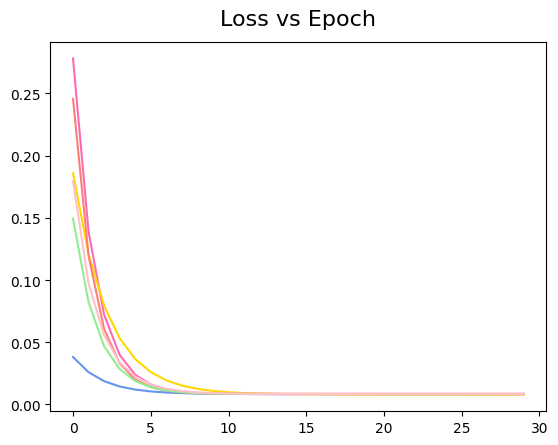

In [71]:
done_losses = {} #dictionary
gotten_results = {}
outputs = []
saved_params = []
numIters = 5

saved_loss_arrays = []

from concurrent.futures import ProcessPoolExecutor as Executor
saved_thread_nums = []
with Executor() as executor:
  for i in range(0,numIters):
    thread_num = "t" + str(i)
    thread_num = executor.submit(training, i)
    saved_thread_nums.append(thread_num)
  
  for i in range(0,numIters):
    #results_of_iteration, outputs, test, initial_params_one = saved_thread_nums[i].result()
    results_of_iteration, outputs, test = saved_thread_nums[i].result()
    #initial_params.append(inital_params_one)
    colors = ["cornflowerblue", "hotpink", "gold", "salmon", "lightgreen", "aqua", "red", "lightpink"]
    plt.plot(np.arange(nTrainSteps), results_of_iteration, color = colors[i%7])
    #print(saved_params)
    #print(test)
    #results_of_iteration, outputs, data_trained = training() #gets current array
    #results_of_iteration, outputs, one_sample, data_trained = training() #gets current array
    #print(results_of_iteration)
    saved_loss_arrays.append(results_of_iteration)
    for j in range(0,nTrainSteps):
      if j in done_losses:
        done_losses[j] += results_of_iteration[j]
      else:
        done_losses[j] = results_of_iteration[j]
    #gotten_results[i] = DNN_model(x_input).squeeze().data
    gotten_results[i] = outputs

average_losses = [0]*nTrainSteps
for i in range(0,nTrainSteps):
  average_losses[i] = done_losses[i]/numIters

avg_results = [0]*len(gotten_results[0])
for i in range(0,numIters):
  for j in range(0,len(gotten_results[i])):
      avg_results[j] += gotten_results[i][j]
  #print(avg_results)
for i in range(0,len(avg_results)):
  avg_results[i] /= numIters

# print("average losses ", average_losses)
#plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses, color = "pink")
#plt.plot(np.arange(nTrainSteps), results_of_iteration, label = "Last iteration", color = "blue")


In [74]:
for i in range(0, len(saved_loss_arrays)):
    print("RESULTS FOR ITERATION, ", i)
    for j in range(0,len(saved_loss_arrays[i])):
        print(saved_loss_arrays[i][j], " loss of ", j, "iteration of trial")
    print("END OF RESULTS FOR ITERATION, ", i)

RESULTS FOR ITERATION,  0
0.038108889013528824  loss of  0 iteration of trial
0.02588549256324768  loss of  1 iteration of trial
0.018674181774258614  loss of  2 iteration of trial
0.01442324835807085  loss of  3 iteration of trial
0.01191815547645092  loss of  4 iteration of trial
0.01044148113578558  loss of  5 iteration of trial
0.009570219554007053  loss of  6 iteration of trial
0.009055295027792454  loss of  7 iteration of trial
0.00875020306557417  loss of  8 iteration of trial
0.008568796329200268  loss of  9 iteration of trial
0.008460420183837414  loss of  10 iteration of trial
0.008395278826355934  loss of  11 iteration of trial
0.008355814032256603  loss of  12 iteration of trial
0.008331671357154846  loss of  13 iteration of trial
0.008316724561154842  loss of  14 iteration of trial
0.008307335898280144  loss of  15 iteration of trial
0.008301339112222195  loss of  16 iteration of trial
0.008297434076666832  loss of  17 iteration of trial
0.008294831961393356  loss of  18 i

test
99
<class 'list'>
[0.21109382068971172, 0.1053168801823631, 0.055035691964440046, 0.029973967093974353, 0.0171212877263315, 0.010396579466760158, 0.006824558484368026, 0.00490481274900958, 0.003863538196310401, 0.003294639789965004, 0.002982040459755808, 0.0028095002402551473, 0.0027139363228343427, 0.0026608717162162066, 0.0026313542621210217, 0.0026149176992475986, 0.002605760551523417, 0.0026006562286056576, 0.0025978072779253127, 0.002596210699994117, 0.0025953060830943286, 0.0025947815156541765, 0.0025944628287106752, 0.002594253548886627, 0.0025941008934751153, 0.0025939760729670525, 0.002593863336369395, 0.002593755000270903, 0.0025936468853615226, 0.0025935376179404557]
<class 'torch.Tensor'>
<class 'torch.Tensor'>


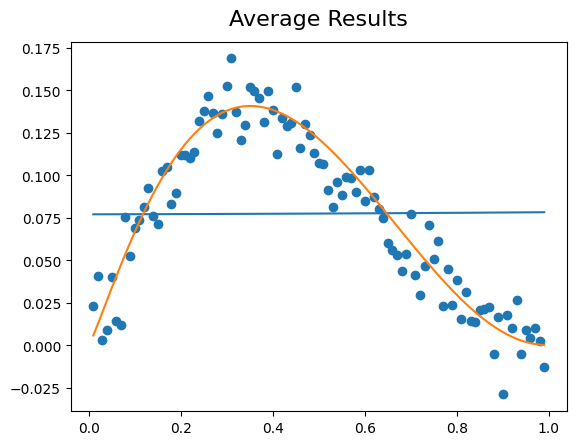

In [ ]:
### I find it useful to plot how the loss evolves during training
print("test")
print(len(avg_results))
print(type(avg_results))
#print(len(data_trained))
#print(type(data_trained.detach().numpy()))
print(average_losses)
print(type(x.data))
print(type(h(x, sig_params).data))
plt.title("Average Results", fontsize = 16, pad = 12)
plt.plot(x.data, avg_results, label = 'Average Fit')
#plt.plot(data_trained, avg_results, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)
# This can tell you if we plateau rapidly, etc

#plt.figure(0)
#plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
#plt.plot(np.arange(nTrainSteps), track_loss)

In [ ]:
### Plot model results, true signal, and noisey data point

'''avg_tensor = torch.tensor(one_sample, dtype=torch.float32)
sorted_tensor = avg_tensor.sort()[0]
#print(type(x.data))
plt.title("One Sample", fontsize = 16, pad = 12)
#FOR LOOP TO .detach().numpy() each value in avg_results???
new_list = [0]*len(avg_results)
for i in range(0,len(new_list)):
  new_list[i] = avg_results[i].detach()
print("test")
print(new_list)
dict_vals = {}
for i in range(0,len(avg_tensor)):
  dict_vals[data_trained[i]] = avg_tensor[i]
sorted_dict_keys = sorted(dict_vals.keys())
sorted_dict = {key: dict_vals[key] for key in sorted_dict_keys}
print(sorted_dict)
new_tensor_list = [0]*len(dict_vals)
new_values_list = [0]*len(dict_vals)
i = 0
for key in sorted_dict:
  new_values_list[i] = key
  new_tensor_list[i] = sorted_dict[key]
  i += 1
print("hi")
print(new_tensor_list)
plt.plot(new_values_list, new_tensor_list, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)'''

'avg_tensor = torch.tensor(one_sample, dtype=torch.float32)\nsorted_tensor = avg_tensor.sort()[0]\n#print(type(x.data))\nplt.title("One Sample", fontsize = 16, pad = 12)\n#FOR LOOP TO .detach().numpy() each value in avg_results???\nnew_list = [0]*len(avg_results)\nfor i in range(0,len(new_list)):\n  new_list[i] = avg_results[i].detach()\nprint("test")\nprint(new_list)\ndict_vals = {}\nfor i in range(0,len(avg_tensor)):\n  dict_vals[data_trained[i]] = avg_tensor[i]\nsorted_dict_keys = sorted(dict_vals.keys())\nsorted_dict = {key: dict_vals[key] for key in sorted_dict_keys}\nprint(sorted_dict)\nnew_tensor_list = [0]*len(dict_vals)\nnew_values_list = [0]*len(dict_vals)\ni = 0\nfor key in sorted_dict:\n  new_values_list[i] = key\n  new_tensor_list[i] = sorted_dict[key]\n  i += 1\nprint("hi")\nprint(new_tensor_list)\nplt.plot(new_values_list, new_tensor_list, label = \'Average Fit\')\nplt.plot(x.data, h(x, sig_params).data, label = \'True PDF\')\nplt.scatter(x.data, X_train[0].data)'

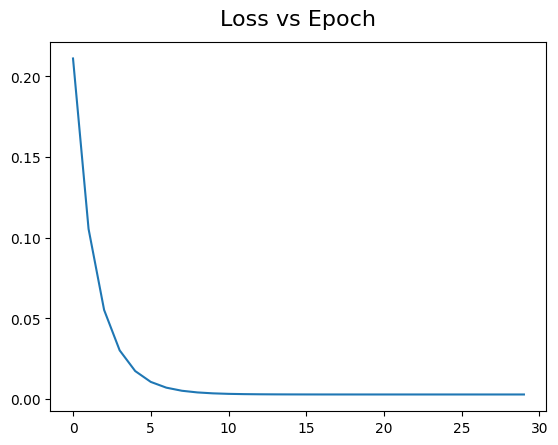

In [ ]:
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses)